In [ ]:
# !pip install mysql-connector-python

In [2]:
import mysql.connector
# library for data analysis
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from tensorflow.keras.optimizers import Adam
import tensorflow as tf
from tensorflow.keras.models import Model 
from tensorflow.keras.layers import Input, Embedding, Dot, Flatten, Dense
from sklearn.model_selection import train_test_split 
from sklearn.metrics.pairwise import cosine_similarity

import os 

In [3]:
# Membuat koneksi ke database
conn = mysql.connector.connect(
    host='localhost',
    user='root',
    password='',
    database='tourista_db'
)

In [4]:
# Mengeksekusi query untuk mengambil data dari tabel

query = "SELECT * FROM destination"
destination = pd.read_sql_query(query, conn)

query = "SELECT * FROM review_wisata"
ratings = pd.read_sql_query(query, conn)

query = "SELECT * FROM user_profile"
users = pd.read_sql_query(query, conn)

C:\Users\dewan\AppData\Local\Temp\ipykernel_17864\707316895.py:4: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  destination = pd.read_sql_query(query, conn)
C:\Users\dewan\AppData\Local\Temp\ipykernel_17864\707316895.py:7: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  ratings = pd.read_sql_query(query, conn)
C:\Users\dewan\AppData\Local\Temp\ipykernel_17864\707316895.py:10: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  users = pd.read_sql_query(query, conn)


### data preprocessing

In [5]:
ratings.head(2)

,user_wisata,wisata_id,wisata_rating
0,1,179,3.0
1,1,344,2.0


In [9]:
ratings = ratings.sort_values('wisata_rating', ascending=False).drop_duplicates(subset=['wisata_id', 'user_wisata'], keep='first')

In [10]:
ratings.shape

(9597, 3)

In [11]:
train, test = train_test_split(ratings, test_size = 0.2)

In [13]:
number_user = len(ratings['user_wisata'].unique())
number_destination = len(ratings['wisata_id'].unique())

print(f'number of user = {number_user}')
print(f'number of place name = {number_destination}')

number of user = 300
number of place name = 437


In [22]:
# build recommendation system using emmbedding layers dan dropout(to overcome the overfitting)

from tensorflow.keras.models import Model 
from tensorflow.keras.layers import Input, Embedding, Dot, Flatten, Dense, Dropout 

EMBEDDING_DIM = 50

# input layers 
place_input = Input(shape=[1])
user_input = Input(shape=[1])

# embedding layers add dropout 
place_embedding = Embedding(number_destination+1 , EMBEDDING_DIM)(place_input)
place_embedding = Dropout(0.2)(place_embedding)

user_embedding = Embedding(number_user+1 , EMBEDDING_DIM)(user_input)
user_embedding = Dropout(0.2)(user_embedding)

# flatten the embedddings
place_flat = Flatten()(place_embedding)
user_flat = Flatten()(user_embedding)

# output layer
output = Dot(1)([place_flat, user_flat])

# the model
model = Model([place_input, user_input], [output])

In [24]:
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam

early_stopping = EarlyStopping(patience=5, restore_best_weights=True)
model.compile(optimizer=Adam(learning_rate = 0.0005), loss='mean_squared_error') 

In [25]:
history = model.fit(x= [train.wisata_id, train.user_wisata], 
                    y= train.wisata_rating, 
                    validation_data = ([train.wisata_id, train.user_wisata], train.wisata_rating), 
                    epochs =100,
                    callbacks=[early_stopping],)

Epoch 1/100
240/240 [==============================] - 2s 4ms/step - loss: 11.4905 - val_loss: 11.4665
Epoch 2/100
240/240 [==============================] - 1s 3ms/step - loss: 11.4625 - val_loss: 11.4298
Epoch 3/100
240/240 [==============================] - 1s 3ms/step - loss: 11.4125 - val_loss: 11.3522
Epoch 4/100
240/240 [==============================] - 1s 3ms/step - loss: 11.2913 - val_loss: 11.1585
Epoch 5/100
240/240 [==============================] - 1s 3ms/step - loss: 10.9919 - val_loss: 10.7075
Epoch 6/100
240/240 [==============================] - 1s 3ms/step - loss: 10.3574 - val_loss: 9.8543
Epoch 7/100
240/240 [==============================] - 1s 3ms/step - loss: 9.3059 - val_loss: 8.5897
Epoch 8/100
240/240 [==============================] - 1s 3ms/step - loss: 7.9134 - val_loss: 7.0543
Epoch 9/100
240/240 [==============================] - 1s 3ms/step - loss: 6.3629 - val_loss: 5.5079
Epoch 10/100
240/240 [==============================] - 1s 3ms/step - loss: 4.90

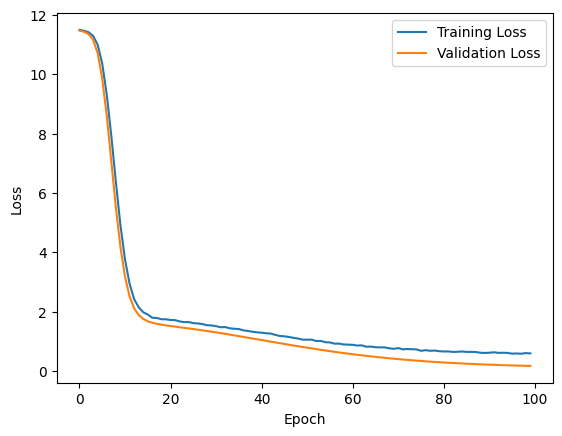

In [26]:
# Plot the training and validation loss
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

## Model result

In [28]:
# calculations for "haversine distance" and complementary functions for collaborative filtering
from math import radians

def haversine_distance(lat1, long1, lat2, long2):
    earth_radius = 6371  # Radius of the Earth in kilometers (source: google)
    lat1_rad = np.radians(lat1)
    long1_rad = np.radians(long1)
    lat2_rad = np.radians(lat2)
    long2_rad = np.radians(long2)
    diff_lat = lat2_rad - lat1_rad
    diff_long = long2_rad - long1_rad
    a = np.sin(diff_lat / 2) ** 2 + np.cos(lat1_rad) * np.cos(lat2_rad) * np.sin(diff_long / 2) ** 2
    c = 2 * np.arcsin(np.sqrt(a))
    distance = earth_radius * c
    return distance

def filter_by_location(destination, user_lat, user_long, max_distance):
    destination['distance'] = haversine_distance(destination['destination_lat'], destination['destination_long'], user_lat, user_long)
    destination = destination[destination['distance'] <= max_distance]
    destination = destination.drop('distance', axis=1)
    return destination

def filter_by_city(destination):
    city_filter = ['Jakarta', 'Bandung', 'Yogyakarta', 'Semarang', 'Surabaya']
    destination = destination[destination['city'].isin(city_filter)]
    return destination

In [43]:
# recommendation system function using collaborative filtering
def collaborative_rec(User_Id, destination ,model, u_lat, u_long, np_val = 6 ):
    """
        User_Id : untuk melakukan rekomendasi berdasarkan User_Id yang diberikan
        destinatin : dataframe dengan format column terdapat "user_wisata, wisata_id, wisata_rating, name_wisata, category, description_wisata, destination_lat, destination_long, destination_photo, city"
        model : model hasil yang sudah di training sebelumnya
        np_val : banyaknya output yang akan diberikan
        u_lat & u_long : berguna untuk menentukan destinasi wisata terdekat dari lat & long yang diberikan
    """
    
    if User_Id in ratings['user_wisata'].values:
            destination = destination.copy()
            user_ids = np.array([User_Id] * len(destination))
            results = model([destination.id.values, user_ids]).numpy().reshape(-1)
    
            destination['predicted_rating'] = pd.Series(results)
            destination = filter_by_location(destination, u_lat, u_long, 30)[:20]
            destination = destination.sort_values('predicted_rating', ascending = False)
    else:
            destination = destination.copy()
            destination = destination.sort_values('rating', ascending = False)  
    
    return destination[['name_wisata', 'city','coordinate', 'destination_photo','description_wisata', 'predicted_rating']][:np_val].to_dict(orient='records')

In [44]:
user_location = 'Bandung'
user_lat = -6.1253
user_long = 106.8335

In [45]:
final_result = collaborative_rec(34, destination, model, user_lat, user_long, )
final_result

[{'name_wisata': 'Jembatan Kota Intan',
  'city': 'Jakarta',
  'coordinate': "{'lat': -6.1314572, 'lng': 106.8106169}",
  'destination_photo': 'lala.png',
  'description_wisata': 'Jembatan Kota Intan adalah jembatan tertua di Indonesia yang dibangun pada tahun 1628 oleh pemerintah Vereenigde Oostindische Compagnie atau VOC, atau masyarakat kita lebih familiar dengan sebutan Kumpeni. Jembatan itu kini terletak di Kali Besar kawasan ',
  'predicted_rating': 4.536832332611084},
 {'name_wisata': 'Museum Nasional',
  'city': 'Jakarta',
  'coordinate': "{'lat': -6.176402099999999, 'lng': 106.8215901}",
  'destination_photo': 'lala.png',
  'description_wisata': 'Museum Nasional Republik Indonesia atau Museum Gajah, adalah sebuah museum arkeologi, sejarah, etnografi, dan geografi yang terletak di Jakarta Pusat dan persisnya di Jalan Merdeka Barat 12. Museum ini merupakan museum pertama dan terbesar di Asia Tenggar',
  'predicted_rating': 4.045568466186523},
 {'name_wisata': 'Atlantis Water Adv

## Pretraining model

In [46]:
tf.keras.models.save_model(model, 'pretrained_collab_rec')

INFO:tensorflow:Assets written to: pretrained_collab_rec\assets


INFO:tensorflow:Assets written to: pretrained_collab_rec\assets


In [48]:
# Example of loading pretrained model

loaded_model =  tf.keras.models.load_model('pretrained_collab_rec')

pretrained_result = collaborative_rec(34, destination, loaded_model, user_lat, user_long)
print(pretrained_result==final_result)

True


In [188]:
model.summary()

Model: "model_6"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_13 (InputLayer)          [(None, 1)]          0           []                               
                                                                                                  
 input_14 (InputLayer)          [(None, 1)]          0           []                               
                                                                                                  
 embedding_12 (Embedding)       (None, 1, 50)        21900       ['input_13[0][0]']               
                                                                                                  
 embedding_13 (Embedding)       (None, 1, 50)        15050       ['input_14[0][0]']               
                                                                                            

In [189]:
loaded_model.summary()

Model: "model_6"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_13 (InputLayer)          [(None, 1)]          0           []                               
                                                                                                  
 input_14 (InputLayer)          [(None, 1)]          0           []                               
                                                                                                  
 embedding_12 (Embedding)       (None, 1, 50)        21900       ['input_13[0][0]']               
                                                                                                  
 embedding_13 (Embedding)       (None, 1, 50)        15050       ['input_14[0][0]']               
                                                                                            